In [ ]:
! pip install SimpleITK
! pip install nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.5 MB/s eta 0:00:00


In [1]:
import SimpleITK as sitk
import numpy as np
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import nibabel as nib
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [33]:
%run "C:\Users\johnm\Downloads\utils.ipynb"  #utils.ipynb

# Visualizing one image

In [ ]:
# image = sitk.ReadImage("../picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory KIM
image = sitk.ReadImage("../data/picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory EMILIA

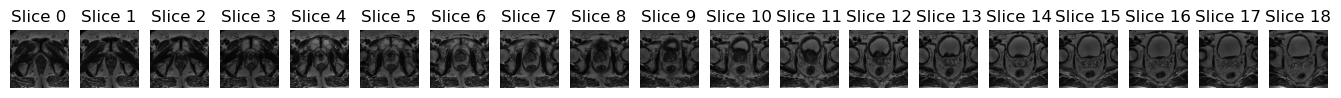

In [ ]:
#this is to display the image
image_array = sitk.GetArrayFromImage(image)

# Display slices of the image using Matplotlib
num_slices = image_array.shape[0]  # Assuming the first dimension is the number of slices
fig, axes = plt.subplots(1, num_slices, figsize=(17, 4))
for i in range(num_slices):
    axes[i].imshow(image_array[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Slice {i}")
plt.show()

# Merging images with label in one dictionary

In [ ]:
# directory = "/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1"
directory = "../data/picai_public_images_fold1"

In [7]:
##### ADD A KEY FOR AGE

# tarang updated this to make it a function

def make_dict(directory, multi_fold = False, dict_images = {}):

  if multi_fold:
    print('fold')
    folds = os.listdir(directory)
    for f in folds:
      fold_path = os.path.join(directory, f)
      print(fold_path)
      make_dict(fold_path, False, dict_images)
    return dict_images
  else:
    print('datapoint')
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder) # /Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10010/10010_1000010
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if "t2w" in file_name and file_name.endswith('.mha'):
                    full_path = os.path.join(directory, folder, file_name)
                    if os.path.exists(full_path):
                        short_name = '_'.join(file_name.split('_')[:2])
                        image = sitk.ReadImage(full_path)
                        dict_images[short_name] = {'image': image, 'case_pca': None, 'patient_age': None, 'patient_id': None}
    return dict_images


In [8]:
dict_images = {}

# previous code:
#dict_images = make_dict(directory, False, dict_images)

# updating this to what works for me, change it back to directory and False when running

#from google.colab import drive
#drive.mount('/content/drive')

directory = "D:\Downloads\Luna Training Data"
folds = os.listdir(directory)

print(folds)

dict_images = make_dict(directory, True, dict_images)

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
C:\Users\johnm\AppData\Local\Temp\ipykernel_29524\153236583.py:11: SyntaxWarning: invalid escape sequence '\D'
  directory = "D:\Downloads\Luna Training Data"


['picai_public_images_fold0', 'picai_public_images_fold1', 'picai_public_images_fold2', 'picai_public_images_fold3', 'picai_public_images_fold4']
fold
D:\Downloads\Luna Training Data\picai_public_images_fold0
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold1
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold2
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold3
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold4
datapoint


In [10]:
print(list(dict_images.keys())[0])

dict_images[list(dict_images.keys())[0]]

10000_1000000


{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000015580A078D0> >,
 'case_pca': None,
 'patient_age': None,
 'patient_id': None}

In [11]:
#size of the dictionary
len(dict_images)

1500

We stored 3 things:
* the nii files that have the color coded images
* the labels for each image (from csv file)
* the age of patients for each image (from csv file)

# Opening nii files

In [ ]:
# path = '../10035_1000035.nii'


In [ ]:
# img = nib.load(path).get_fdata()
# img.shape

In [ ]:
# print(f"The .nii files are stored in memory as numpy's: {type(img)}.")


In [ ]:
# plt.style.use('default')
# fig, axes = plt.subplots(4,4, figsize=(12,12))
# for i, ax in enumerate(axes.reshape(-1)):
#     ax.imshow(img[:,:,1 + i])
# plt.show()

# Using the CSV file to get the labels and patients' age

In this spreadsheet, there is a column "lesion_GS", which lists the outcomes:

Gleason score (GS) assigned to each lesion after histopathologic analysis, where scores for different lesions are separated by , (commas). If its value is missing, then no tissue sampling procedure was performed; indicating a negative MRI study. If its value is N/A only for specific lesion(s), then those lesion(s) (as observed in radiology) were not biopsied or graded in histopathology (typically the case for PI-RADS 1-2 lesions).

This means that any case that contains a Gleason score of 7 (3+4 or higher) harbors csPCa, while all other cases are considered negative for csPCa. For more details on how this ground truth was derived, you can also check out our study design.


In [17]:
# tarang

# drive.flush_and_unmount()

labels_path = "C:\\Users\johnm\Downloads\marksheet.csv"

<>:5: SyntaxWarning: invalid escape sequence '\j'
<>:5: SyntaxWarning: invalid escape sequence '\j'
C:\Users\johnm\AppData\Local\Temp\ipykernel_29524\3956456944.py:5: SyntaxWarning: invalid escape sequence '\j'
  labels_path = "C:\\Users\johnm\Downloads\marksheet.csv"


In [ ]:
# labels_path = "../marksheet.csv"
labels_path = "../data/marksheet.csv"

In [18]:
df = pd.read_csv(labels_path)

In [19]:
df.head(100)

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
95,10095,1000095,2017-02-09,65,9.20,NaN,60.0,MRBx,0+0,0,0,NO
96,10096,1000096,2011-12-31,64,22.33,0.66,34.0,MRBx,0+0,0,0,NO
97,10097,1000097,2018-11-27,66,15.01,NaN,32.0,MRBx,3+4,2,2,YES
98,10098,1000098,2012-03-29,69,12.00,0.17,69.0,NaN,NaN,NaN,0,NO


### Evaluating class imbalance

In [20]:
df['case_csPCa'].value_counts()

case_csPCa
NO     1075
YES     425
Name: count, dtype: int64

Combining them both

## Combining patient_id and study_id to get the full differentiator per patient

In [21]:
df['full_name'] = df['patient_id'].astype(str) + '_' + df['study_id'].astype(str)

In [22]:
df

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,full_name
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO,10000_1000000
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO,10001_1000001
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO,10002_1000002
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO,10003_1000003
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO,10004_1000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,YES,11471_1001495
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,YES,11472_1001496
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,NO,11473_1001497
1498,11474,1001498,2016-05-03,71,12.00,NaN,83.0,MRBx,3+3,1,1,NO,11474_1001498


### Testing

In [23]:
specific_full_name = '10000_1000000'
case_csPCA_value = df.loc[df['full_name'] == specific_full_name, 'case_csPCa'].iloc[0]
case_csPCA_value

'NO'

## Adding to a dictionary based on thier full name

In [24]:
not_found = 0
found = 0

for f in df['full_name']:
    if f in dict_images:
        print(f"Found {f}")
        case_csPCa_value = df.loc[df['full_name'] == f, 'case_csPCa'].iloc[0]
        patient_age = df.loc[df['full_name'] == f, 'patient_age'].iloc[0]
        #converting to 0 and 1
        dict_images[f]['case_pca'] = 0 if case_csPCa_value == 'NO' else 1 if case_csPCa_value == 'YES' else None
        dict_images[f]['patient_age'] = patient_age
        dict_images[f]['patient_id'] = f

        found += 1
    else:
        print(f"Could not find {f}")
        not_found += 1

Found 10000_1000000
Found 10001_1000001
Found 10002_1000002
Found 10003_1000003
Found 10004_1000004
Found 10005_1000005
Found 10006_1000006
Found 10007_1000007
Found 10008_1000008
Found 10009_1000009
Found 10010_1000010
Found 10011_1000011
Found 10012_1000012
Found 10013_1000013
Found 10014_1000014
Found 10015_1000015
Found 10016_1000016
Found 10017_1000017
Found 10018_1000018
Found 10019_1000019
Found 10020_1000020
Found 10021_1000021
Found 10022_1000022
Found 10023_1000023
Found 10024_1000024
Found 10025_1000025
Found 10026_1000026
Found 10027_1000027
Found 10028_1000028
Found 10029_1000029
Found 10030_1000030
Found 10031_1000031
Found 10032_1000032
Found 10033_1000033
Found 10034_1000034
Found 10035_1000035
Found 10036_1000036
Found 10037_1000037
Found 10038_1000038
Found 10039_1000039
Found 10040_1000040
Found 10041_1000041
Found 10042_1000042
Found 10043_1000043
Found 10044_1000044
Found 10045_1000045
Found 10046_1000046
Found 10047_1000047
Found 10048_1000048
Found 10049_1000049


In [25]:
found, not_found

(1500, 0)

In [54]:
dict_images

{'10000_1000000': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000015580A078D0> >,
  'case_pca': 0,
  'patient_age': 73,
  'patient_id': '10000_1000000'},
 '10001_1000001': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x00000155803BEBB0> >,
  'case_pca': 0,
  'patient_age': 64,
  'patient_id': '10001_1000001'},
 '10003_1000003': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x000001558104AA00> >,
  'case_pca': 0,
  'patient_age': 72,
  'patient_id': '10003_1000003'},
 '10006_1000006': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x000001558104A9A0> >,
  'case_pca': 0,
  'patient_age': 73,
  'patient_id': '10006_1000006'},
 '10017_1000017': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x000001558104A760> >,
  'case_pca': 0,
  'patient_age': 67,

### Evaluating class imbalance in final sample

In [73]:
# Extract 'case_pca' values from dictionary values
case_pca_values = [item['case_pca'] for item in dict_images.values()]

# Count occurrences of 'YES' and 'NO'
counts = Counter(case_pca_values)
yes_count = counts[1]
no_count = counts[0]

print(f"Count of 'YES': {yes_count}")
print(f"Count of 'NO': {no_count}")

# trying to balance
balanced = {}

positives = {}
for k in dict_images.keys():
  balanced[k] = dict_images[k]
  if dict_images[k]['case_pca'] == 1:
    positives[k] = dict_images[k]

repeats = random.choices(list(positives.keys()), k = no_count - yes_count)

for r in range(len(repeats)):
  balanced[str(repeats[r]) + "r" + str(r)] = positives[repeats[r]]
  print("repeating " + repeats[r])

# check if correctly done
case_pca_values = [item['case_pca'] for item in balanced.values()]

# Count occurrences of 'YES' and 'NO'
counts = Counter(case_pca_values)
yes_count = counts[1]
no_count = counts[0]

print(f"Count of 'YES': {yes_count}")
print(f"Count of 'NO': {no_count}")

Count of 'YES': 425
Count of 'NO': 1075
repeating 10369_1000375
repeating 10760_1000776
repeating 11332_1001355
repeating 10408_1000415
repeating 10376_1000382
repeating 10164_1000167
repeating 10562_1000574
repeating 11032_1001052
repeating 11446_1001470
repeating 10424_1000432
repeating 11181_1001204
repeating 10882_1000898
repeating 10545_1000556
repeating 10094_1000094
repeating 10548_1000560
repeating 10135_1000137
repeating 10053_1000053
repeating 10545_1000556
repeating 10875_1000891
repeating 10484_1000492
repeating 10808_1000824
repeating 10568_1000580
repeating 10202_1000206
repeating 11063_1001085
repeating 11225_1001248
repeating 10252_1000256
repeating 11357_1001380
repeating 10577_1000590
repeating 10434_1000442
repeating 10522_1000532
repeating 10383_1000389
repeating 10442_1000450
repeating 11190_1001213
repeating 11283_1001306
repeating 11451_1001475
repeating 10961_1000980
repeating 10048_1000048
repeating 10682_1000698
repeating 11367_1001390
repeating 10857_1000873


In [28]:
#our dictionary with the T2w images and the case_csPCa values
dict_images

{'10000_1000000': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000015580A078D0> >,
  'case_pca': 0,
  'patient_age': 73,
  'patient_id': '10000_1000000'},
 '10001_1000001': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x00000155803BEBB0> >,
  'case_pca': 0,
  'patient_age': 64,
  'patient_id': '10001_1000001'},
 '10003_1000003': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x000001558104AA00> >,
  'case_pca': 0,
  'patient_age': 72,
  'patient_id': '10003_1000003'},
 '10006_1000006': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x000001558104A9A0> >,
  'case_pca': 0,
  'patient_age': 73,
  'patient_id': '10006_1000006'},
 '10017_1000017': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x000001558104A760> >,
  'case_pca': 0,
  'patient_age': 67,

In [74]:
# balanced dictionary

balanced

{'10000_1000000': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000015580A078D0> >,
  'case_pca': 0,
  'patient_age': 73,
  'patient_id': '10000_1000000'},
 '10001_1000001': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x00000155803BEBB0> >,
  'case_pca': 0,
  'patient_age': 64,
  'patient_id': '10001_1000001'},
 '10003_1000003': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x000001558104AA00> >,
  'case_pca': 0,
  'patient_age': 72,
  'patient_id': '10003_1000003'},
 '10006_1000006': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x000001558104A9A0> >,
  'case_pca': 0,
  'patient_age': 73,
  'patient_id': '10006_1000006'},
 '10017_1000017': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x000001558104A760> >,
  'case_pca': 0,
  'patient_age': 67,

In [29]:
dict_images[list(dict_images.keys())[0]]

{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000015580A078D0> >,
 'case_pca': 0,
 'patient_age': 73,
 'patient_id': '10000_1000000'}

# Image Preprocessing

In [75]:
## Images
images = [forresnet(entry['image']) for entry in balanced.values()]

Streaming output truncated to the last 5000 lines.
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (640, 640)
Shape after adding dimension: (640, 640, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
S

# Train Test Split

In [77]:
labels = [entry['case_pca'] for entry in balanced.values()]
ages = [entry['patient_age'] for entry in balanced.values()]

X_train, X_test, y_train, y_test, age_train, age_test = train_test_split(images, labels, ages, test_size=0.2, random_state = 42)

#split for validations sets
X_train, X_val, y_train, y_val, age_train, age_val = train_test_split(X_train, y_train, age_train, test_size=0.2, random_state = 42)


X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
age_train = np.array(age_train)
age_val = np.array(age_val)
age_test = np.array(age_test)

### Evaluating class imbalance in train, test, and validation sets

In [78]:
# Count labels in X_train
train_label_counts = Counter(y_train)
print("Train Label Counts:", train_label_counts)

# Count labels in X_val
val_label_counts = Counter(y_val)
print("Validation Label Counts:", val_label_counts)

# Count labels in X_test
test_label_counts = Counter(y_test)
print("Test Label Counts:", test_label_counts)


Train Label Counts: Counter({1: 697, 0: 679})
Validation Label Counts: Counter({0: 180, 1: 164})
Test Label Counts: Counter({0: 216, 1: 214})


In [37]:
X_train.shape, X_val.shape, X_test.shape

((960, 224, 224, 3), (240, 224, 224, 3), (300, 224, 224, 3))

# Baseline Model: ResNet50

In [ ]:
# model = tf.keras.applications.ResNet50()

In [79]:
# Load pre-trained ResNet-50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = Dense(128, activation='relu')(x)  # Add a dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Add an output layer for binary classification

# Combine the base model and new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape        ┃     Param # ┃ Connected to        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2         │ (None, 224, 224, 3) │           0 │ -                   │
│ (InputLayer)          │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ conv1_pad             │ (None, 230, 230, 3) │           0 │ input_layer_2[0][0] │
│ (ZeroPadding2D)       │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ conv1_conv (Conv2D)   │ (None, 112, 112,    │       9,472 │ conv1_pad[0][0]     │
│                       │ 64)                 │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ conv1_bn              │ (None, 112, 112,    │         256 │ conv1_conv[0][0]    │
│ (BatchNormalization)  │ 64)                 │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ conv1_relu            │ (None, 112, 112,    │           0 │ conv1_bn[0][0]      │
│ (Activation)          │ 64)                 │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ pool1_pad             │ (None, 114, 114,    │           0 │ conv1_relu[0][0]    │
│ (ZeroPadding2D)       │ 64)                 │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ pool1_pool            │ (None, 56, 56, 64)  │           0 │ pool1_pad[0][0]     │
│ (MaxPooling2D)        │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ conv2_block1_1_conv   │ (None, 56, 56, 64)  │       4,160 │ pool1_pool[0][0]    │
│ (Conv2D)              │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ conv2_block1_1_bn     │ (None, 56, 56, 64)  │         256 │ conv2_block1_1_con… │
│ (BatchNormalization)  │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ conv2_block1_1_relu   │ (None, 56, 56, 64)  │           0 │ conv2_block1_1_bn[… │
│ (Activation)          │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ conv2_block1_2_conv   │ (None, 56, 56, 64)  │      36,928 │ conv2_block1_1_rel… │
│ (Conv2D)              │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ conv2_block1_2_bn     │ (None, 56, 56, 64)  │         256 │ conv2_block1_2_con… │
│ (BatchNormalization)  │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ conv2_block1_2_relu   │ (None, 56, 56, 64)  │           0 │ conv2_block1_2_bn[… │
│ (Activation)          │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ conv2_block1_0_conv   │ (None, 56, 56, 256) │      16,640 │ pool1_pool[0][0]    │
│ (Conv2D)              │                     │             │                     │
├───────────────────────┼─────────────────────┼─────────────┼─────────────────────┤
│ conv2_block1_3_conv   │ (None, 56, 56, 256) │      16,640 │ conv2_block1_2_rel… │
│ (Conv2D)              │                     │             │                     │
├───────────────────────┼─────────────────────┼─────

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [80]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 916ms/step - accuracy: 0.5101 - loss: 0.7434 - val_accuracy: 0.5581 - val_loss: 0.6831
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 876ms/step - accuracy: 0.5608 - loss: 0.6791 - val_accuracy: 0.5610 - val_loss: 0.6805
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 874ms/step - accuracy: 0.5950 - loss: 0.6514 - val_accuracy: 0.5698 - val_loss: 0.6600
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 886ms/step - accuracy: 0.6166 - loss: 0.6333 - val_accuracy: 0.5901 - val_loss: 0.6606
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 868ms/step - accuracy: 0.6511 - loss: 0.6187 - val_accuracy: 0.5552 - val_loss: 0.6864
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 872ms/step - accuracy: 0.6105 - loss: 0.6290 - val_accuracy: 0.5901 - val_loss: 0.6749
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 861ms/step - accuracy: 0.6258 - loss: 0.6294 - val_accuracy: 0.6541 - val_loss: 0.6286
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 869ms/step - accuracy: 0.6945 - loss: 0.5844 - val_accu

In [81]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 666ms/step - accuracy: 0.6359 - loss: 0.6443
Test accuracy: 0.630232572555542


## Performance Evaluation

43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 685ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 847ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 664ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.721657,0.661856,0.921090,0.770246
Validation,0.613372,0.561265,0.865854,0.681055
Test,0.630233,0.586207,0.873832,0.701689


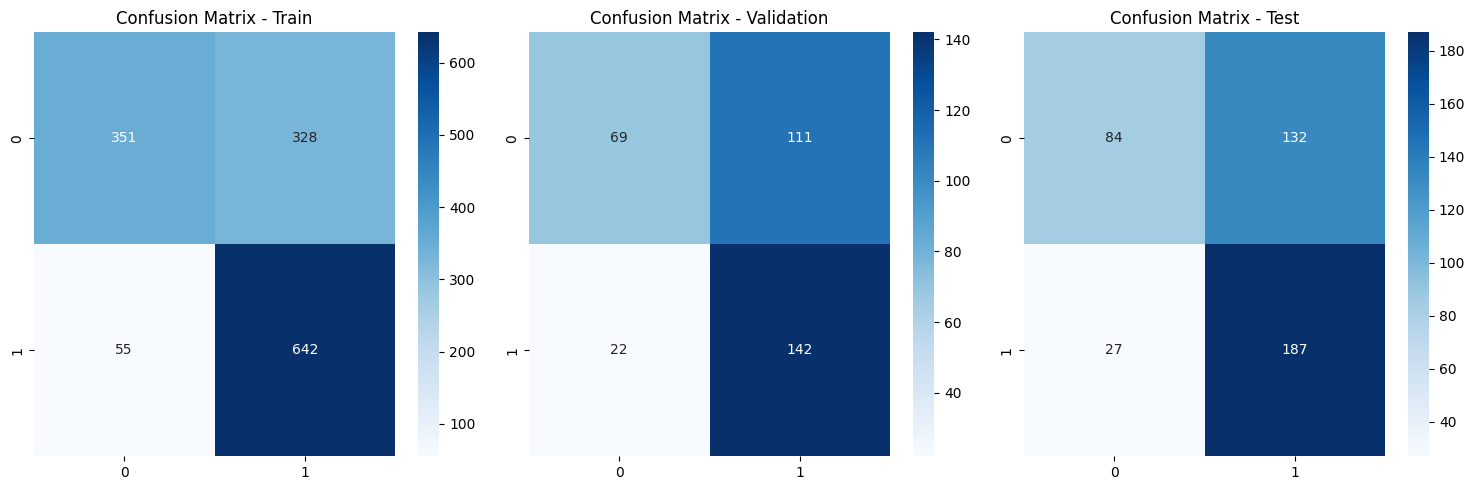

In [82]:
metrics_df = evaluate_model(model, 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

# Experiment 3: Multimodal Model

## Preprocessing Tabular data post train-test split (normalizing age)

In [ ]:
scaler = StandardScaler()

#train
age_train_normalized = scaler.fit_transform(age_train.reshape(-1,1))

#test
age_val_normalized = scaler.transform(age_val.reshape(-1, 1))
age_test_normalized = scaler.transform(age_test.reshape(-1, 1))

## 3.1. Ensemble Approach

## 3.2. Data Concatenation Approach